In [5]:
import numpy as np
import pandas as pd 

In [6]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  auc, accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler


In [12]:
test_data = pd.read_csv('C:/Users/kjsum/Downloads/fraudTest.csv/fraudTest.csv')
train_data = pd.read_csv('C:/Users/kjsum/Downloads/fraudTrain.csv/fraudTrain.csv')

In [13]:
train_data.tail(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.9,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.24116,0
1296674,1296674,2020-06-21 12:13:37,4292902571056973207,"fraud_Langosh, Wintheiser and Hyatt",food_dining,4.3,Jeffrey,Smith,M,135 Joseph Mountains,...,45.8433,-113.8748,218,"Therapist, horticultural",1995-08-16,8f7c8e4ab7f25875d753b422917c98c9,1371816817,46.565983,-114.18611,0


In [14]:
merged_data = pd.concat([train_data, test_data], axis=0)

# Reset the index if needed
merged_data.reset_index(drop=True, inplace=True)

# Save the merged dataset to a new CSV file
merged_data.to_csv('merged_data.csv', index=False)

In [15]:
df = pd.read_csv('merged_data.csv')
df.shape

(1852394, 23)

In [16]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df.dtypes['trans_date_trans_time']

# Derive 'Transaction Hour' Feature from 'Transaction Time' Feature
df['time'] = df['trans_date_trans_time'].dt.strftime('%H:%M:%S')
df['time']

# Derive 'Day of Week' Feature from 'Transaction Time' Feature
df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()
df['day_of_week']

# Derive 'month - year' feature
df['Month']  = pd.DatetimeIndex(df['trans_date_trans_time']).month
df['Year'] = pd.DatetimeIndex(df['trans_date_trans_time']).year

# Convert 'DOB' to datetime if it's not already
df['dob'] = pd.to_datetime(df['dob'])
# Calculate age
current_date = pd.Timestamp('now')
df['age'] = current_date.year - df['dob'].dt.year

# Sort the DataFrame by the "age" column in ascending order
df.sort_values(by='age')

df['age']

# Define the age groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20','21-40','41-60', '61-80', '81-100']

# Use the cut function to create the age_group feature
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

# Display the DataFrame with the new age_group feature
df['age_group']

# Convert 'DOB' to datetime if it's not already
df['dob'] = pd.to_datetime(df['dob'])
# Calculate age
current_date = pd.Timestamp('now')
df['age'] = current_date.year - df['dob'].dt.year

# Sort the DataFrame by the "age" column in ascending order
df.sort_values(by='age')

df['age']

# Define the age groups
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20','21-40','41-60', '61-80', '81-100']

# Use the cut function to create the age_group feature
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

# Display the DataFrame with the new age_group feature
df['age_group']

0          21-40
1          41-60
2          61-80
3          41-60
4          21-40
           ...  
1852389    41-60
1852390    21-40
1852391    41-60
1852392    41-60
1852393    21-40
Name: age_group, Length: 1852394, dtype: category
Categories (5, object): ['0-20' < '21-40' < '41-60' < '61-80' < '81-100']

In [17]:
df.gender=df.gender.apply(lambda x: 1 if x=="M" else 0)

In [18]:
columns_to_drop = ['Unnamed: 0','cc_num','merchant','trans_date_trans_time','city','lat','long','job','dob','merch_lat','merch_long']

# Use the drop method to remove the specified columns
df = df.drop(columns=columns_to_drop)

In [19]:
columns_drop = ['trans_num','unix_time','first','last','street','zip','age_group','day_of_week', 'state','time']

# Use the drop method to remove the specified columns
df = df.drop(columns=columns_drop)

In [20]:
df = pd.get_dummies(df, columns=['category'], prefix='category')

df = df.reindex(columns=df.columns, fill_value=0)

In [21]:
df['category_entertainment']=df['category_entertainment'].astype(int)

df['category_kids_pets']=df['category_kids_pets'].astype(int)

df['category_shopping_pos']=df['category_shopping_pos'].astype(int)

df['category_travel']=df['category_travel'].astype(int)

df['category_health_fitness']=df['category_health_fitness'].astype(int)

df['category_home']=df['category_home'].astype(int)

df['category_misc_pos']=df['category_misc_pos'].astype(int)

df['category_shopping_net']=df['category_shopping_net'].astype(int)

df['category_gas_transport']=df['category_gas_transport'].astype(int)

df['category_misc_net']=df['category_misc_net'].astype(int)

df['category_grocery_net']=df['category_grocery_net'].astype(int)

df['category_kids_pets']=df['category_kids_pets'].astype(int)

df['category_personal_care'] = df['category_personal_care'].astype(int)
 
df['category_grocery_pos'] = df['category_grocery_pos'].astype(int)


In [22]:
df.head(2)

,amt,gender,city_pop,is_fraud,Month,Year,age,category_entertainment,category_food_dining,category_gas_transport,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,4.97,0,3495,0,1,2019,35,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,107.23,0,149,0,1,2019,45,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [23]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1481915, 20), (370479, 20), (1481915,), (370479,))

In [25]:
lr_non_oversampled = LogisticRegression(random_state=42)
lr_non_oversampled.fit(X_train, y_train)

LogisticRegression(random_state=42)

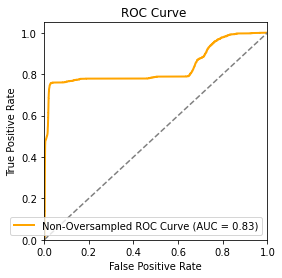

In [26]:
y_proba_non_oversampled_lr = lr_non_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_lr)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled_lr)

# Plot ROC curve for non-oversampled model
plt.figure(figsize=(4, 4))
plt.plot(fpr_non_oversampled, tpr_non_oversampled, color='orange', lw=2, label=f'Non-Oversampled ROC Curve (AUC = {auc_non_oversampled:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.legend(loc='lower right')
plt.show()



Logistic Regression Classifier :
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    368526
           1       0.00      0.00      0.00      1953

    accuracy                           0.99    370479
   macro avg       0.50      0.50      0.50    370479
weighted avg       0.99      0.99      0.99    370479

Accuracy: 0.99


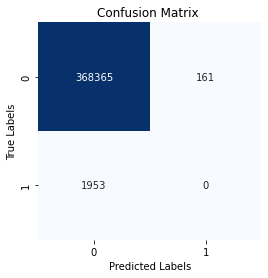

In [27]:
y_pred_non_oversampled = lr_non_oversampled.predict(X_test)

# Create confusion matrix for non-oversampled model
cm_non_oversampled = confusion_matrix(y_test, y_pred_non_oversampled)

# Create heatmap for non-oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm_non_oversampled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ')


# Evaluate the non-oversampled model
print("\nLogistic Regression Classifier :")
print("Classification Report:")
print(classification_report(y_test, y_pred_non_oversampled))

accuracy = accuracy_score(y_test, y_pred_non_oversampled)
print(f"Accuracy: {accuracy:.2f}")


plt.show()

In [28]:
rf_non_oversampled = RandomForestClassifier(random_state=42)
rf_non_oversampled.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

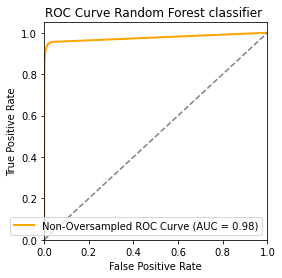

In [29]:
y_proba_non_oversampled_rf = rf_non_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_rf)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled_rf)

# Plot ROC curve for non-oversampled Random Forest model
plt.figure(figsize=(4, 4))
plt.plot(fpr_non_oversampled, tpr_non_oversampled, color='orange', lw=2, label=f'Non-Oversampled ROC Curve (AUC = {auc_non_oversampled:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest classifier ')
plt.legend(loc='lower right')
plt.show()


Random Forest Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.87      0.70      0.78      1953

    accuracy                           1.00    370479
   macro avg       0.93      0.85      0.89    370479
weighted avg       1.00      1.00      1.00    370479

Accuracy: 1.00


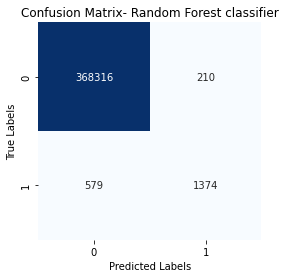

In [30]:
y_pred_non_oversampled = rf_non_oversampled.predict(X_test)

# Create confusion matrix for non-oversampled model
cm_non_oversampled = confusion_matrix(y_test, y_pred_non_oversampled)

# Create heatmap for non-oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm_non_oversampled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix- Random Forest classifier')

# Evaluate the non-oversampled model
print("\nRandom Forest Classifier:")
print("Classification Report:")
print(classification_report(y_test, y_pred_non_oversampled))

accuracy = accuracy_score(y_test, y_pred_non_oversampled)
print(f"Accuracy: {accuracy:.2f}")


plt.show()


In [31]:
xgb_non_oversampled = XGBClassifier(random_state=42)
xgb_non_oversampled.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

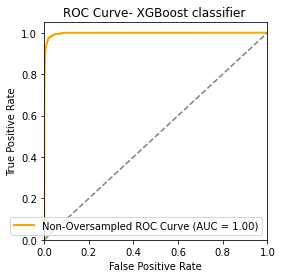

In [32]:
y_proba_non_oversampled_x = xgb_non_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_x)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled_x)

# Plot ROC curve for non-oversampled XGBoost model
plt.figure(figsize=(4, 4))
plt.plot(fpr_non_oversampled, tpr_non_oversampled, color='orange', lw=2, label=f'Non-Oversampled ROC Curve (AUC = {auc_non_oversampled:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- XGBoost classifier ')
plt.legend(loc='lower right')
plt.show()


XGBoost Classifier:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.87      0.66      0.75      1953

    accuracy                           1.00    370479
   macro avg       0.94      0.83      0.88    370479
weighted avg       1.00      1.00      1.00    370479

Accuracy: 1.00


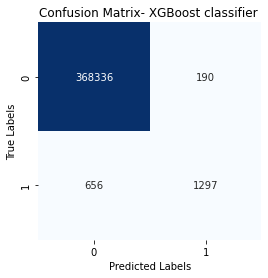

In [33]:
y_pred_non_oversampled = xgb_non_oversampled.predict(X_test)

# Create confusion matrix for non-oversampled model
cm_non_oversampled = confusion_matrix(y_test, y_pred_non_oversampled)

# Create heatmap for non-oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm_non_oversampled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix- XGBoost classifier ')

# Evaluate the non-oversampled model
print("\nXGBoost Classifier:")
print("Classification Report:")
print(classification_report(y_test, y_pred_non_oversampled))
accuracy = accuracy_score(y_test, y_pred_non_oversampled)
print(f"Accuracy: {accuracy:.2f}")


plt.show()

In [34]:
dt_non_oversampled = DecisionTreeClassifier(random_state=42)
dt_non_oversampled.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

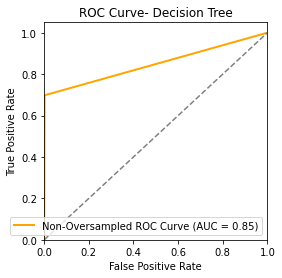

In [35]:
y_proba_non_oversampled = dt_non_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled)

# Plot ROC curve for non-oversampled Decision Tree model
plt.figure(figsize=(4, 4))
plt.plot(fpr_non_oversampled, tpr_non_oversampled, color='orange', lw=2, label=f'Non-Oversampled ROC Curve (AUC = {auc_non_oversampled:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Decision Tree')
plt.legend(loc='lower right')
plt.show()



Decision Tree Classifier :
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.68      0.70      0.69      1953

    accuracy                           1.00    370479
   macro avg       0.84      0.85      0.84    370479
weighted avg       1.00      1.00      1.00    370479

Accuracy: 1.00


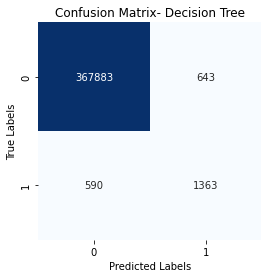

In [36]:
y_pred_non_oversampled = dt_non_oversampled.predict(X_test)

# Create confusion matrix for non-oversampled model
cm_non_oversampled = confusion_matrix(y_test, y_pred_non_oversampled)

# Create heatmap for non-oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm_non_oversampled, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix- Decision Tree')

# Evaluate the non-oversampled model
print("\nDecision Tree Classifier :")
print("Classification Report:")
print(classification_report(y_test, y_pred_non_oversampled))
accuracy = accuracy_score(y_test, y_pred_non_oversampled)
print(f"Accuracy: {accuracy:.2f}")


plt.show()

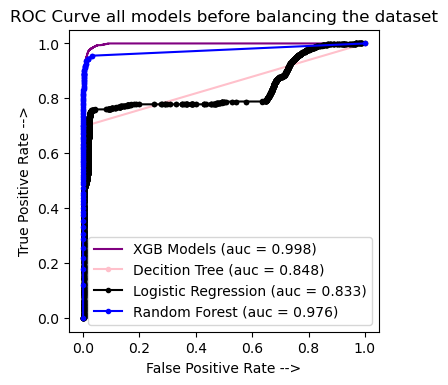

In [37]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the non-oversampled test set
y_proba_non_oversampled_x = xgb_non_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled_x, tpr_non_oversampled_x, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_x)
auc_non_oversampled_x = roc_auc_score(y_test, y_proba_non_oversampled_x)

# Predict probabilities on the non-oversampled test set
y_proba_non_oversampled_lr = lr_non_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled_lr, tpr_non_oversampled_lr, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_lr)
auc_non_oversampled_lr = roc_auc_score(y_test, y_proba_non_oversampled_lr)

# Predict probabilities on the non-oversampled test set
y_proba_non_oversampled_rf = rf_non_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled_rf, tpr_non_oversampled_rf, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled_rf)
auc_non_oversampled_rf = roc_auc_score(y_test, y_proba_non_oversampled_rf)

# Predict probabilities on the non-oversampled test set
y_proba_non_oversampled = dt_non_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score for non-oversampled model
fpr_non_oversampled, tpr_non_oversampled, thresholds_non_oversampled = roc_curve(y_test, y_proba_non_oversampled)
auc_non_oversampled = roc_auc_score(y_test, y_proba_non_oversampled)


plt.figure(figsize=(4, 4), dpi=100)
plt.plot(fpr_non_oversampled_x, tpr_non_oversampled_x, linestyle='-',color='purple', label='XGB Models (auc = %0.3f)' % auc_non_oversampled_x)
plt.plot(fpr_non_oversampled, tpr_non_oversampled, marker='.',color='pink' ,label='Decition Tree (auc = %0.3f)' % auc_non_oversampled)
plt.plot(fpr_non_oversampled_lr, tpr_non_oversampled_lr, marker='.',color='black' ,label='Logistic Regression (auc = %0.3f)' % auc_non_oversampled_lr)
plt.plot(fpr_non_oversampled_rf, tpr_non_oversampled_rf, marker='.',color='blue' ,label='Random Forest (auc = %0.3f)' % auc_non_oversampled_rf)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title('ROC Curve all models before balancing the dataset')
plt.legend(loc='lower right')
plt.legend()
plt.show()

In [38]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [39]:
lr_oversampled = LogisticRegression(random_state=42)
lr_oversampled.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

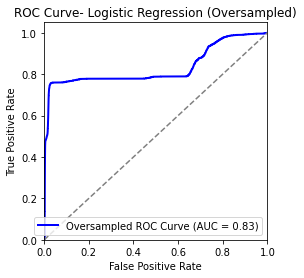

In [40]:
y_proba = lr_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve for oversampled model
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Oversampled ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression (Oversampled)')
plt.legend(loc='lower right')
plt.show()

Logistic Regression Classifier with Oversampling:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98    368526
           1       0.08      0.76      0.14      1953

    accuracy                           0.95    370479
   macro avg       0.54      0.86      0.56    370479
weighted avg       0.99      0.95      0.97    370479

Accuracy: 0.95


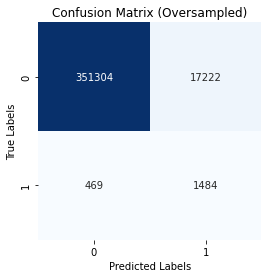

In [41]:
y_pred = lr_oversampled.predict(X_test)

# Create confusion matrix for oversampled model
cm = confusion_matrix(y_test, y_pred)

# Create heatmap for oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Oversampled)')

# Evaluate the oversampled model
print("Logistic Regression Classifier with Oversampling:")
print("Classification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.show()

In [42]:
rf_oversampled = RandomForestClassifier(random_state=42)
rf_oversampled.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

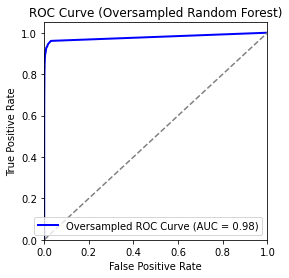

In [43]:
y_proba = rf_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve for oversampled Random Forest model
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Oversampled ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Oversampled Random Forest)')
plt.legend(loc='lower right')
plt.show()

Random Forest Classifier with Oversampling:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.83      0.77      0.80      1953

    accuracy                           1.00    370479
   macro avg       0.91      0.88      0.90    370479
weighted avg       1.00      1.00      1.00    370479

Accuracy: 1.00


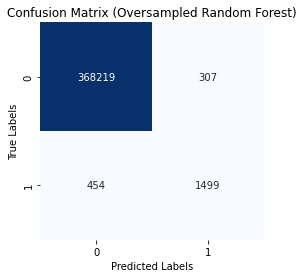

In [44]:
y_pred = rf_oversampled.predict(X_test)

# Create confusion matrix for oversampled model
cm = confusion_matrix(y_test, y_pred)

# Create heatmap for oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Oversampled Random Forest)')

# Evaluate the oversampled model
print("Random Forest Classifier with Oversampling:")
print("Classification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.show()

In [45]:
xgb_oversampled = XGBClassifier(random_state=42)
xgb_oversampled.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

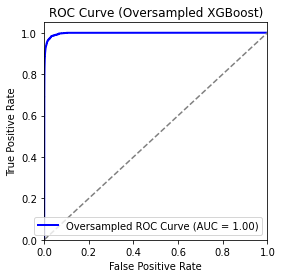

In [46]:
y_proba = xgb_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve for oversampled XGBoost model
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Oversampled ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Oversampled XGBoost)')
plt.legend(loc='lower right')
plt.show()

XGBoost Classifier with Oversampling:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    368526
           1       0.24      0.96      0.38      1953

    accuracy                           0.98    370479
   macro avg       0.62      0.97      0.69    370479
weighted avg       1.00      0.98      0.99    370479

Accuracy: 0.98


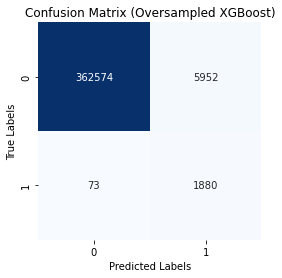

In [47]:
y_pred = xgb_oversampled.predict(X_test)

# Create confusion matrix for oversampled model
cm = confusion_matrix(y_test, y_pred)

# Create heatmap for oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Oversampled XGBoost)')

# Evaluate the oversampled model
print("XGBoost Classifier with Oversampling:")
print("Classification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.show()

In [48]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
X_train_resampled.shape, y_train_resampled.shape

((2948434, 20), (2948434,))

In [49]:
dt_oversampled = DecisionTreeClassifier(random_state=42)
dt_oversampled.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

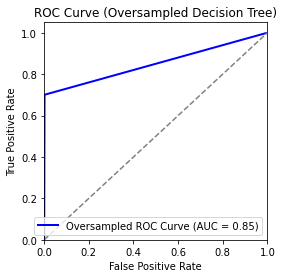

In [50]:
y_proba = dt_oversampled.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC-ROC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve for oversampled Decision Tree model
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Oversampled ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Oversampled Decision Tree)')
plt.legend(loc='lower right')
plt.show()

Decision Tree Classifier with Oversampling:
Classification Report:
accuracy Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368526
           1       0.72      0.70      0.71      1953

    accuracy                           1.00    370479
   macro avg       0.86      0.85      0.85    370479
weighted avg       1.00      1.00      1.00    370479

Accuracy: 1.00


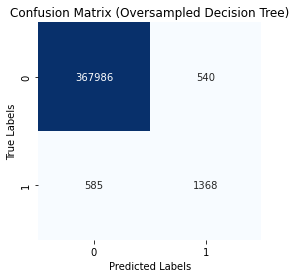

In [51]:
y_pred = dt_oversampled.predict(X_test)

# Create confusion matrix for oversampled model
cm = confusion_matrix(y_test, y_pred)

# Create heatmap for oversampled model
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Oversampled Decision Tree)')

# Evaluate the oversampled model
print("Decision Tree Classifier with Oversampling:")
print("Classification Report:")
print("accuracy Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

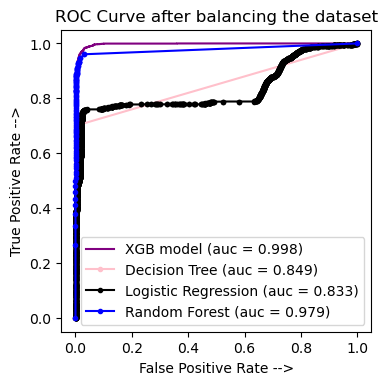

In [52]:
y_proba = xgb_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_proba)
auc_xgb = roc_auc_score(y_test, y_proba)

# Predict probabilities on the non-oversampled test set
y_proba_dt = dt_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score
fpr_dt, tpr_dt, thresholds = roc_curve(y_test, y_proba_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

# Predict probabilities on the non-oversampled test set
y_proba_rf = rf_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

##lr
# Predict probabilities on the non-oversampled test set
y_proba_lr = lr_oversampled.predict_proba(X_test)[:, 1]
# Calculate ROC curve and AUC-ROC score
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

plt.figure(figsize=(4, 4), dpi=100)
plt.plot(fpr_xgb, tpr_xgb, linestyle='-',color='purple', label='XGB model (auc = %0.3f)' % auc_xgb)
plt.plot(fpr_dt, tpr_dt, marker='.',color='pink' ,label='Decision Tree (auc = %0.3f)' % auc_dt)
plt.plot(fpr_lr, tpr_lr, marker='.',color='black' ,label='Logistic Regression (auc = %0.3f)' % auc_lr)
plt.plot(fpr_rf, tpr_rf, marker='.',color='blue' ,label='Random Forest (auc = %0.3f)' % auc_rf)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.title('ROC Curve after balancing the dataset')
plt.legend(loc='lower right')
plt.legend()
plt.show()